In [5]:
import matplotlib.pyplot as plt
import numpy as np

### Load data ###

In [6]:
def read_off(filename):
    """
    Reads an OFF or NOFF file of oriented points.

    Parameters:
    - filename (str): Path to the OFF/NOFF file.

    Returns:
    - points (np.ndarray): Array of points (vertices) with shape (n, 3).
    - normals (np.ndarray or None): Array of normals with shape (n, 3), or None if not present.
    """
    X = []
    N = []

    with open(filename, 'r') as infile:
        # Read and parse the header
        header = infile.readline().strip()
        if header not in {"OFF", "NOFF"}:
            raise ValueError(f"Invalid OFF file header: {header}")
        
        # Read the second line (number of vertices, faces, edges)
        info = infile.readline().strip()
        nvertices, nfaces, nedges = map(int, info.split())
        
        # Read the vertices (and optionally normals if NOFF)
        for _ in range(nvertices):
            line = infile.readline().strip()
            values = list(map(float, line.split()))
            
            x, y, z = values[:3]
            X.append([x, y, z])
            
            if header == "NOFF" and len(values) >= 6:  # If NOFF, normals are included
                nx, ny, nz = values[3:6]
                N.append([nx, ny, nz])
    
    # Convert lists to numpy arrays
    X = np.array(X)
    N = np.array(N) if N else None

    return X, N


In [7]:
data = read_off("cat.off")
X, N = data[0], data[1]


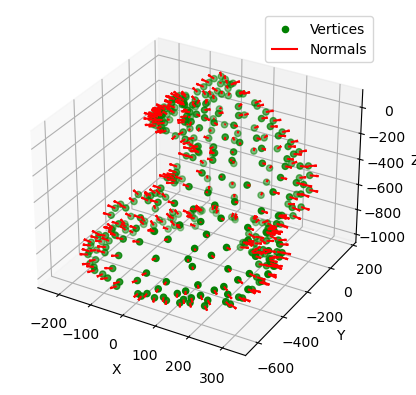

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot vertices
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='g', label="Vertices", s=20)  # s controls marker size

# Plot normals using quiver
ax.quiver(X[:, 0], X[:, 1], X[:, 2],  # Starting points of arrows
          N[:, 0], N[:, 1], N[:, 2],  # Directions of arrows (normals)
          length=25, normalize=True, color='r', label="Normals")  # Adjust length as needed

# Add legend
ax.legend()

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()
